In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_x_base = pd.read_csv("train_features.csv")
train_y = pd.read_csv("train_labels.csv")
test_x = pd.read_csv("test_features.csv")

classification_labels = [
    "LABEL_BaseExcess",
    "LABEL_Fibrinogen",
    "LABEL_AST",
    "LABEL_Alkalinephos",
    "LABEL_Bilirubin_total",
    "LABEL_Lactate",
    "LABEL_TroponinI",
    "LABEL_SaO2",
    "LABEL_Bilirubin_direct",
    "LABEL_EtCO2",
]
sepsis_label = "LABEL_Sepsis"
regression_labels = [
    "LABEL_RRate",
    "LABEL_ABPm",
    "LABEL_SpO2",
    "LABEL_Heartrate",
]

train_y.set_index("pid", inplace=True)
train_y.head()

,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
pid,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5
100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.5,88.3,96.5,108.1
1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,19.4,77.2,98.3,80.9
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,76.8,97.7,95.3


In [2]:
train_x_base.drop("Time", axis=1, inplace=True)
train_x = train_x_base.groupby("pid", sort=False)
train_x_age = train_x[["Age"]].mean()

train_x_base.drop("Age", axis=1, inplace=True)
train_x = train_x_base.groupby("pid", sort=False)

train_x = (
    train_x_age.join(train_x.mean(), rsuffix="_mean")
    .join(train_x.max(), rsuffix="_max")
    .join(train_x.min(), rsuffix="_min")
    .join(train_x.var(), rsuffix="_var")
    .join(train_x.count(), rsuffix="_count")
    .join(train_x.std(), rsuffix="_std")
    .join(train_x.skew(), rsuffix="_skew")
    .join(train_x.median(), rsuffix="_median")
    .join(train_x.quantile(0.25), rsuffix="_q25")
    .join(train_x.quantile(0.75), rsuffix="_q75")
    .join(train_x.quantile(0.1), rsuffix="_q10")
    .join(train_x.quantile(0.9), rsuffix="_q90")
    .join(train_x.quantile(0.05), rsuffix="_q05")
    .join(train_x.quantile(0.95), rsuffix="_q95")
    .join(train_x.quantile(0.01), rsuffix="_q01")
    .join(train_x.quantile(0.99), rsuffix="_q99")
    .join(train_x.quantile(0.001), rsuffix="_q001")
    .join(train_x.quantile(0.999), rsuffix="_q999")
)
train_x.fillna(0, inplace=True)
train_x.head()

,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,...,Alkalinephos_q999,SpO2_q999,Bilirubin_direct_q999,Chloride_q999,Hct_q999,Heartrate_q999,Bilirubin_total_q999,TroponinI_q999,ABPs_q999,pH_q999
pid,,,,,,,,,,,,,,,,,,,,,
1,34.0,0.000000,0.00,12.0,0.000,36.750000,8.566667,25.333333,-0.666667,17.000000,...,0.0,100.000,0.0,113.994,24.596,98.945,0.0,0.00,141.813,7.40988
10,71.0,0.000000,27.80,12.0,0.000,36.000000,14.600000,0.000000,0.000000,18.090909,...,68.0,99.000,0.0,0.000,42.100,88.000,1.3,0.01,151.930,0.00000
100,68.0,0.000000,20.90,21.0,0.000,36.250000,12.500000,27.000000,0.000000,14.833333,...,0.0,99.989,0.0,101.000,36.800,127.934,0.0,0.00,157.720,0.00000
1000,79.0,31.863636,0.00,22.0,3.855,36.818182,9.200000,0.000000,0.000000,12.000000,...,0.0,100.000,0.0,0.000,27.300,110.000,0.0,0.00,184.900,7.30000
10000,76.0,0.000000,28.55,22.0,0.000,36.750000,10.700000,25.500000,1.500000,12.090909,...,0.0,100.000,0.0,103.999,31.298,90.000,0.0,0.00,151.890,7.41994


In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_x_scaled = StandardScaler().fit_transform(train_x)
pca = PCA()
pca.fit(train_x_scaled)
pd.Series(data=pca.singular_values_, index=train_x.columns).sort_values()

In [46]:
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# from sklearn.impute import SimpleImputer

# N = 10000
# train_x_sample, train_y_sample = train_x.iloc[:N, :], train_y.iloc[:N, :]

# X_train, X_test, y_train, y_test = train_test_split(
#     train_x_sample, train_y_sample, test_size=0.33, random_state=42
# )

X_train, y_train = train_x, train_y

# model_reg = make_pipeline(
#     StandardScaler(), LinearSVR(random_state=0, tol=1e-5)
# )

# model_clf = make_pipeline(
#     StandardScaler(), LinearSVC(random_state=42, tol=1e-5)
# )

model_clf = GradientBoostingClassifier()
model_reg = GradientBoostingRegressor()

# model_clf = XGBClassifier()
# model_reg = XGBRegressor()


reg = MultiOutputRegressor(model_reg).fit(X_train, y_train[regression_labels])
clf = MultiOutputClassifier(model_clf).fit(
    X_train, y_train[classification_labels + [sepsis_label]]
)

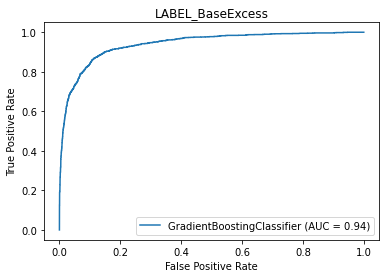

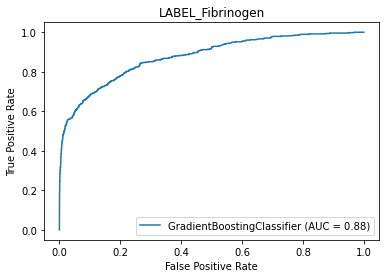

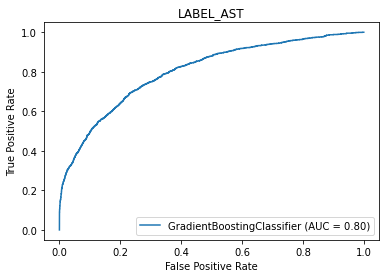

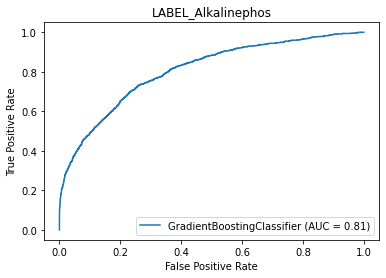

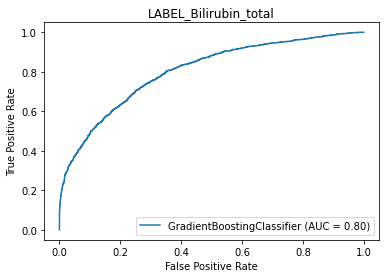

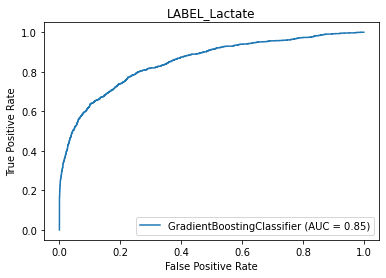

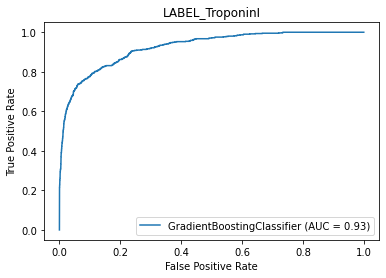

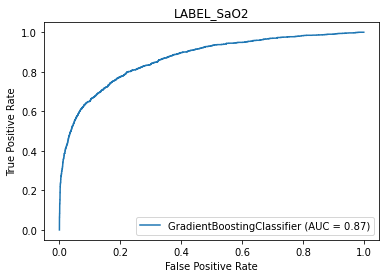

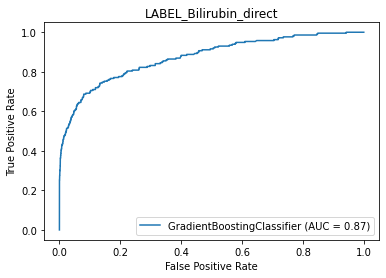

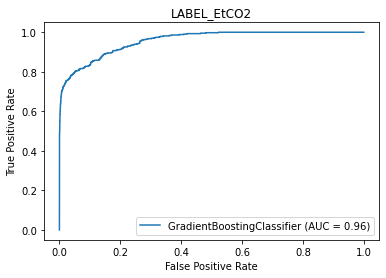

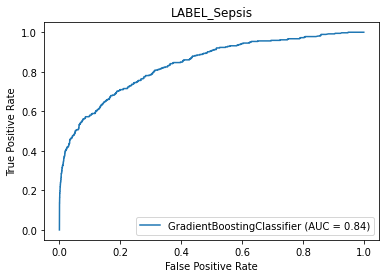

TASK 1: 0.8705148321519605
TASK 2: 0.8385656810335227


In [47]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

for idx, entry in enumerate(classification_labels + [sepsis_label]):
    g = plot_roc_curve(clf.estimators_[idx], X_test, y_test[entry])
    g.ax_.set_title(entry)
    plt.show()

task1 = np.mean(
    [
        roc_auc_score(
            y_test[entry], clf.estimators_[idx].decision_function(X_test)
        )
        for idx, entry in enumerate(classification_labels)
    ]
)
task2 = roc_auc_score(
    y_test[sepsis_label], clf.estimators_[-1].decision_function(X_test)
)
print("TASK 1:", task1)
print("TASK 2:", task2)

In [44]:
from sklearn.metrics import r2_score

task3 = np.mean(
    [
        0.5
        + 0.5
        * np.maximum(
            0, r2_score(y_test[entry], reg.estimators_[idx].predict(X_test))
        )
        for idx, entry in enumerate(regression_labels)
    ]
)
print("TASK 3:", task3)

TASK 3: 0.7474742014893718


In [45]:
print("FINAL SCORE", (task1 + task2 + task3) / 3)

FINAL SCORE 0.7705632786523932


In [51]:
X = pd.read_csv("test_features.csv")

# Preprocessing
X.drop("Time", axis=1, inplace=True)
X_grouped = X.groupby("pid", sort=False)
X_age = X_grouped[["Age"]].mean()

X.drop("Age", axis=1, inplace=True)
X_grouped = X.groupby("pid", sort=False)

X = (
    X_age.join(X_grouped.mean(), rsuffix="_mean")
    .join(X_grouped.max(), rsuffix="_max")
    .join(X_grouped.min(), rsuffix="_min")
    .join(X_grouped.var(), rsuffix="_var")
    .join(X_grouped.count(), rsuffix="_count")
    .join(X_grouped.std(), rsuffix="_std")
    .join(X_grouped.skew(), rsuffix="_skew")
    .join(X_grouped.median(), rsuffix="_median")
    .join(X_grouped.quantile(0.25), rsuffix="_q25")
    .join(X_grouped.quantile(0.75), rsuffix="_q75")
    .join(X_grouped.quantile(0.1), rsuffix="_q10")
    .join(X_grouped.quantile(0.9), rsuffix="_q90")
)
train_x.fillna(0, inplace=True)
X.fillna(0, inplace=True)
X.head()

,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,...,Alkalinephos_q90,SpO2_q90,Bilirubin_direct_q90,Chloride_q90,Hct_q90,Heartrate_q90,Bilirubin_total_q90,TroponinI_q90,ABPs_q90,pH_q90
pid,,,,,,,,,,,,,,,,,,,,,
0,39.0,0.0,41.35,18.5,0.00,36.000000,9.65,14.5,-6.5,11.714286,...,118.0,100.0,0.0,101.6,30.49,90.0,25.94,0.0,138.4,7.394
10001,62.0,0.0,0.00,0.0,0.00,37.250000,0.00,0.0,0.0,16.666667,...,0.0,96.1,0.0,0.0,0.00,124.0,0.00,0.0,122.4,0.000
10003,72.0,0.0,0.00,0.0,2.01,36.909091,0.00,0.0,0.0,16.818182,...,0.0,100.0,0.0,0.0,0.00,94.0,0.00,0.0,127.0,7.508
10004,44.0,0.0,0.00,10.0,0.00,36.250000,12.70,0.0,0.0,13.857143,...,123.0,100.0,0.0,0.0,37.50,91.0,0.20,0.0,110.0,0.000
10005,88.0,0.0,39.90,42.0,0.00,36.000000,8.80,25.0,0.0,19.272727,...,0.0,98.0,0.0,108.0,29.60,62.0,0.00,0.0,143.4,0.000


In [52]:
reg_df = pd.DataFrame(
    index=X.index, columns=regression_labels, data=reg.predict(X)
)
clf_df = pd.DataFrame(
    index=X.index,
    columns=classification_labels,
    data=np.array(
        [
            clf.estimators_[idx].decision_function(X)
            for idx, entry in enumerate(classification_labels)
        ]
    ).T,
)
clf_df[sepsis_label] = clf.estimators_[-1].decision_function(X)

pd.concat([reg_df, clf_df], axis=1).to_csv(
    "submission.rar", float_format="%.3f", compression="zip"
)